PyTorch version: 2.1.2
CUDA version: 12.1



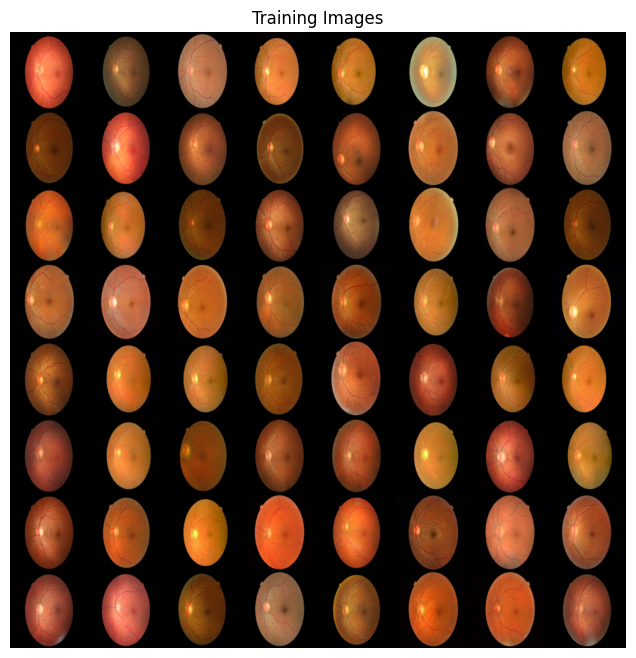

In [18]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
import cv2
from cv2 import dnn_superres

DATA_PATH = '/kaggle/input/training-data-1024x1024/Test'
BATCH_SIZE = 128
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 128
D_HIDDEN = 64
EPOCH_NUM = 5000
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 0.0002
seed = 1

CUDA = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
if CUDA:
    print(f"CUDA version: {torch.version.cuda}\n")

torch.cuda.manual_seed(seed)

device = torch.device("cuda" if CUDA else "cpu")
cudnn.benchmark = True

# Data preprocessing
dataset = dset.ImageFolder(root=DATA_PATH,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [19]:
# create Generator and Discriminator
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class generator(nn.Module):
    # initializers
    def __init__(self, d=G_HIDDEN):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIM, d*16, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*16)
        self.deconv2 = nn.ConvTranspose2d(d*16, d*8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*8)
        self.deconv3 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*4)
        self.deconv4 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d*2)
        self.deconv5 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d)
        self.deconv6 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        # 1x1 -> 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64 -> 128x128

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        x = F.tanh(self.deconv6(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=D_HIDDEN):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d*16, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d*16)
        self.conv6 = nn.Conv2d(d*16, 1, 4, 1, 0)
        # 1x1 <- 4x4 <- 8x8 <- 16x16 <- 32x32 <- 64x64 <- 128x128

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        x = F.sigmoid(self.conv6(x))

        return x
    
# Create the generator
netG = generator()
# netG = nn.DataParallel(netG)
netG.to(device)
print(netG)

# Create the discriminator
netD = discriminator()
# netD = nn.DataParallel(netD)
netD.to(device)
print(netD)

generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv5_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2)

In [20]:
def display_images(img_list):
    # Plot some fake images
    fake_batch = img_list[-1] #next(iter(img_list))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device), nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

Starting Training Loop...
[1/5000][0/9]	Loss_D: 0.0021	Loss_G: 12.7737	D(x): 0.9998	D(G(z)): 0.0019 / 0.0000
[2/5000][0/9]	Loss_D: 0.0015	Loss_G: 10.2582	D(x): 0.9987	D(G(z)): 0.0002 / 0.0001
[3/5000][0/9]	Loss_D: 0.0057	Loss_G: 6.6491	D(x): 1.0000	D(G(z)): 0.0056 / 0.0063
[4/5000][0/9]	Loss_D: 0.0014	Loss_G: 11.7986	D(x): 1.0000	D(G(z)): 0.0014 / 0.0001
[5/5000][0/9]	Loss_D: 0.0001	Loss_G: 10.6438	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[6/5000][0/9]	Loss_D: 0.0001	Loss_G: 10.2536	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[7/5000][0/9]	Loss_D: 0.0004	Loss_G: 9.3410	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[8/5000][0/9]	Loss_D: 0.0032	Loss_G: 7.5786	D(x): 0.9999	D(G(z)): 0.0031 / 0.0008
[9/5000][0/9]	Loss_D: 0.0046	Loss_G: 8.9283	D(x): 1.0000	D(G(z)): 0.0043 / 0.0009
[10/5000][0/9]	Loss_D: 0.0006	Loss_G: 10.7599	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[11/5000][0/9]	Loss_D: 0.0003	Loss_G: 14.3217	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[12/5000][0/9]	Loss_D: 0.2001	Loss_G: 16.1179	D(x): 1.0000	D(G(

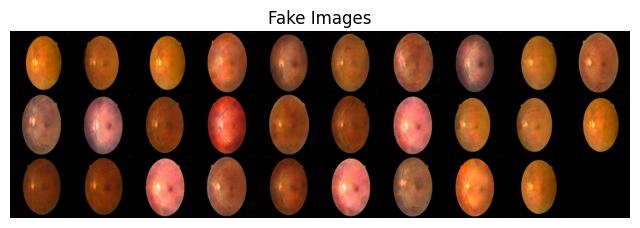

[101/5000][0/9]	Loss_D: 0.0085	Loss_G: 5.6726	D(x): 1.0000	D(G(z)): 0.0084 / 0.0091
[102/5000][0/9]	Loss_D: 0.0007	Loss_G: 8.1905	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[103/5000][0/9]	Loss_D: 0.0023	Loss_G: 7.4570	D(x): 0.9993	D(G(z)): 0.0016 / 0.0014
[104/5000][0/9]	Loss_D: 0.0006	Loss_G: 8.3277	D(x): 1.0000	D(G(z)): 0.0006 / 0.0005
[105/5000][0/9]	Loss_D: 0.0101	Loss_G: 6.6262	D(x): 1.0000	D(G(z)): 0.0093 / 0.0029
[106/5000][0/9]	Loss_D: 0.0056	Loss_G: 5.9854	D(x): 1.0000	D(G(z)): 0.0055 / 0.0053
[107/5000][0/9]	Loss_D: 0.0091	Loss_G: 6.1168	D(x): 0.9984	D(G(z)): 0.0075 / 0.0041
[108/5000][0/9]	Loss_D: 2.3751	Loss_G: 29.0972	D(x): 1.0000	D(G(z)): 0.6663 / 0.0000
[109/5000][0/9]	Loss_D: 0.0022	Loss_G: 9.9351	D(x): 1.0000	D(G(z)): 0.0021 / 0.0012
[110/5000][0/9]	Loss_D: 0.0051	Loss_G: 7.6499	D(x): 1.0000	D(G(z)): 0.0049 / 0.0016
[111/5000][0/9]	Loss_D: 0.0302	Loss_G: 7.7436	D(x): 0.9742	D(G(z)): 0.0009 / 0.0016
[112/5000][0/9]	Loss_D: 0.0007	Loss_G: 8.4400	D(x): 1.0000	D(G(z)): 0.0007 

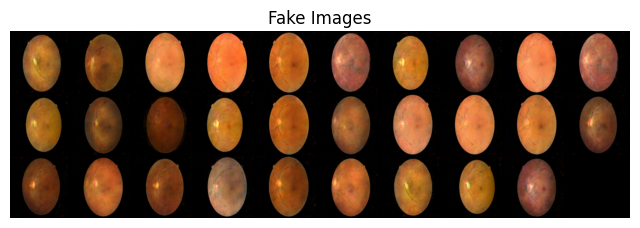

[201/5000][0/9]	Loss_D: 0.0240	Loss_G: 6.5285	D(x): 0.9990	D(G(z)): 0.0222 / 0.0026
[202/5000][0/9]	Loss_D: 0.0038	Loss_G: 7.2927	D(x): 1.0000	D(G(z)): 0.0037 / 0.0025
[203/5000][0/9]	Loss_D: 0.0004	Loss_G: 12.4112	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[204/5000][0/9]	Loss_D: 0.0046	Loss_G: 6.3503	D(x): 1.0000	D(G(z)): 0.0046 / 0.0048
[205/5000][0/9]	Loss_D: 0.0011	Loss_G: 8.7924	D(x): 0.9993	D(G(z)): 0.0003 / 0.0003
[206/5000][0/9]	Loss_D: 0.0005	Loss_G: 8.8549	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[207/5000][0/9]	Loss_D: 0.0011	Loss_G: 7.9870	D(x): 0.9999	D(G(z)): 0.0010 / 0.0009
[208/5000][0/9]	Loss_D: 0.0069	Loss_G: 6.0428	D(x): 1.0000	D(G(z)): 0.0069 / 0.0040
[209/5000][0/9]	Loss_D: 0.0086	Loss_G: 5.9972	D(x): 0.9987	D(G(z)): 0.0072 / 0.0110
[210/5000][0/9]	Loss_D: 0.0003	Loss_G: 8.9639	D(x): 1.0000	D(G(z)): 0.0003 / 0.0004
[211/5000][0/9]	Loss_D: 0.0002	Loss_G: 9.9059	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[212/5000][0/9]	Loss_D: 0.0012	Loss_G: 7.8520	D(x): 1.0000	D(G(z)): 0.0012 

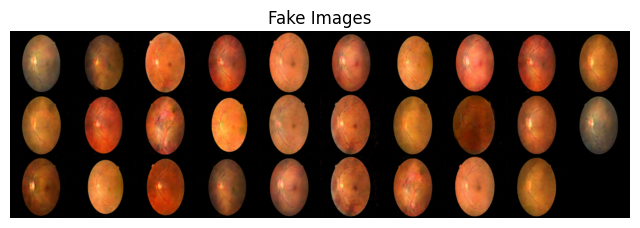

[301/5000][0/9]	Loss_D: 0.0007	Loss_G: 10.9370	D(x): 1.0000	D(G(z)): 0.0006 / 0.0005
[302/5000][0/9]	Loss_D: 0.0015	Loss_G: 9.6204	D(x): 1.0000	D(G(z)): 0.0015 / 0.0013
[303/5000][0/9]	Loss_D: 0.0007	Loss_G: 10.2511	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005
[304/5000][0/9]	Loss_D: 0.0115	Loss_G: 8.2616	D(x): 1.0000	D(G(z)): 0.0113 / 0.0071
[305/5000][0/9]	Loss_D: 0.0007	Loss_G: 9.9285	D(x): 1.0000	D(G(z)): 0.0007 / 0.0008
[306/5000][0/9]	Loss_D: 0.0003	Loss_G: 11.3862	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[307/5000][0/9]	Loss_D: 0.0005	Loss_G: 10.5981	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[308/5000][0/9]	Loss_D: 0.0026	Loss_G: 8.1122	D(x): 1.0000	D(G(z)): 0.0026 / 0.0020
[309/5000][0/9]	Loss_D: 0.0005	Loss_G: 10.2574	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002
[310/5000][0/9]	Loss_D: 0.0006	Loss_G: 10.1087	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002
[311/5000][0/9]	Loss_D: 0.0009	Loss_G: 8.9283	D(x): 0.9999	D(G(z)): 0.0008 / 0.0006
[312/5000][0/9]	Loss_D: 0.1169	Loss_G: 13.0146	D(x): 1.0000	D(G(z)): 0

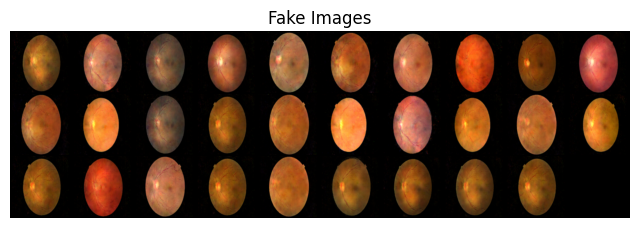

[401/5000][0/9]	Loss_D: 0.0015	Loss_G: 8.2719	D(x): 0.9997	D(G(z)): 0.0012 / 0.0049
[402/5000][0/9]	Loss_D: 0.0020	Loss_G: 7.2765	D(x): 0.9999	D(G(z)): 0.0019 / 0.0016
[403/5000][0/9]	Loss_D: 0.0005	Loss_G: 10.7172	D(x): 0.9997	D(G(z)): 0.0002 / 0.0001
[404/5000][0/9]	Loss_D: 0.0035	Loss_G: 7.2764	D(x): 0.9990	D(G(z)): 0.0025 / 0.0020
[405/5000][0/9]	Loss_D: 0.0023	Loss_G: 7.6178	D(x): 0.9991	D(G(z)): 0.0015 / 0.0012
[406/5000][0/9]	Loss_D: 0.0063	Loss_G: 6.6702	D(x): 0.9993	D(G(z)): 0.0055 / 0.0070
[407/5000][0/9]	Loss_D: 0.0096	Loss_G: 6.0081	D(x): 0.9996	D(G(z)): 0.0091 / 0.0045
[408/5000][0/9]	Loss_D: 0.0049	Loss_G: 6.6340	D(x): 0.9998	D(G(z)): 0.0046 / 0.0030
[409/5000][0/9]	Loss_D: 0.0008	Loss_G: 8.8390	D(x): 0.9997	D(G(z)): 0.0005 / 0.0003
[410/5000][0/9]	Loss_D: 1.7034	Loss_G: 20.0100	D(x): 1.0000	D(G(z)): 0.5264 / 0.0000
[411/5000][0/9]	Loss_D: 0.0441	Loss_G: 8.1190	D(x): 1.0000	D(G(z)): 0.0380 / 0.0021
[412/5000][0/9]	Loss_D: 1.3341	Loss_G: 14.2221	D(x): 1.0000	D(G(z)): 0.374

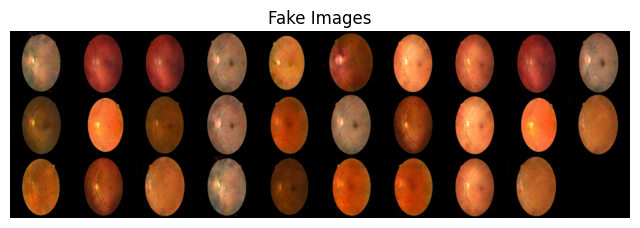

[501/5000][0/9]	Loss_D: 0.0011	Loss_G: 8.0242	D(x): 0.9998	D(G(z)): 0.0009 / 0.0008
[502/5000][0/9]	Loss_D: 0.0006	Loss_G: 9.5032	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002
[503/5000][0/9]	Loss_D: 0.0024	Loss_G: 8.6562	D(x): 0.9979	D(G(z)): 0.0004 / 0.0004
[504/5000][0/9]	Loss_D: 0.0028	Loss_G: 6.9394	D(x): 0.9999	D(G(z)): 0.0027 / 0.0147
[505/5000][0/9]	Loss_D: 0.0008	Loss_G: 9.4490	D(x): 0.9996	D(G(z)): 0.0004 / 0.0004
[506/5000][0/9]	Loss_D: 0.3238	Loss_G: 13.0227	D(x): 1.0000	D(G(z)): 0.1949 / 0.0001
[507/5000][0/9]	Loss_D: 0.0012	Loss_G: 9.4082	D(x): 0.9999	D(G(z)): 0.0010 / 0.0008
[508/5000][0/9]	Loss_D: 0.0009	Loss_G: 10.6070	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002
[509/5000][0/9]	Loss_D: 0.0003	Loss_G: 11.1874	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[510/5000][0/9]	Loss_D: 0.0048	Loss_G: 10.1499	D(x): 0.9955	D(G(z)): 0.0002 / 0.0002
[511/5000][0/9]	Loss_D: 0.0006	Loss_G: 9.2992	D(x): 0.9999	D(G(z)): 0.0006 / 0.0005
[512/5000][0/9]	Loss_D: 8.1021	Loss_G: 31.2345	D(x): 1.0000	D(G(z)): 0.8

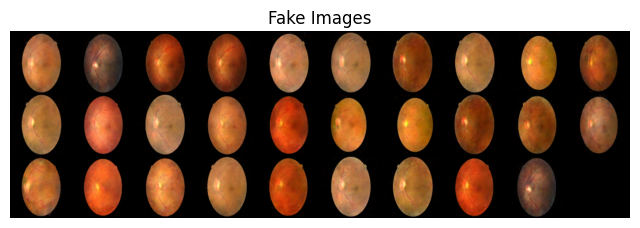

[601/5000][0/9]	Loss_D: 0.0029	Loss_G: 7.2023	D(x): 1.0000	D(G(z)): 0.0029 / 0.0029
[602/5000][0/9]	Loss_D: 0.0003	Loss_G: 9.6431	D(x): 1.0000	D(G(z)): 0.0002 / 0.0006
[603/5000][0/9]	Loss_D: 0.0004	Loss_G: 9.8084	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[604/5000][0/9]	Loss_D: 0.0012	Loss_G: 7.8098	D(x): 1.0000	D(G(z)): 0.0012 / 0.0011
[605/5000][0/9]	Loss_D: 0.0009	Loss_G: 8.5558	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007
[606/5000][0/9]	Loss_D: 0.0023	Loss_G: 7.3665	D(x): 0.9993	D(G(z)): 0.0016 / 0.0014
[607/5000][0/9]	Loss_D: 0.0128	Loss_G: 6.5680	D(x): 0.9899	D(G(z)): 0.0024 / 0.0030
[608/5000][0/9]	Loss_D: 0.0018	Loss_G: 7.4409	D(x): 0.9994	D(G(z)): 0.0013 / 0.0012
[609/5000][0/9]	Loss_D: 0.0198	Loss_G: 5.1387	D(x): 0.9994	D(G(z)): 0.0189 / 0.0093
[610/5000][0/9]	Loss_D: 0.0014	Loss_G: 7.9313	D(x): 0.9999	D(G(z)): 0.0012 / 0.0011
[611/5000][0/9]	Loss_D: 1.4288	Loss_G: 15.8064	D(x): 0.9997	D(G(z)): 0.4605 / 0.0000
[612/5000][0/9]	Loss_D: 0.0042	Loss_G: 9.7327	D(x): 0.9999	D(G(z)): 0.0041 

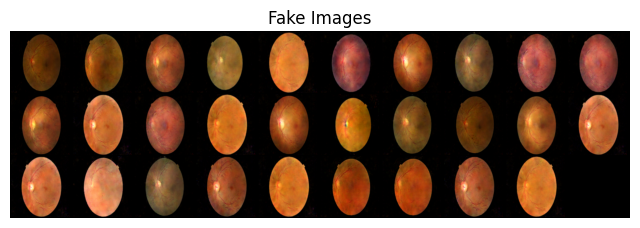

[701/5000][0/9]	Loss_D: 0.0008	Loss_G: 8.0642	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008
[702/5000][0/9]	Loss_D: 0.0005	Loss_G: 8.7501	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004
[703/5000][0/9]	Loss_D: 0.0069	Loss_G: 5.7995	D(x): 0.9999	D(G(z)): 0.0068 / 0.0086
[704/5000][0/9]	Loss_D: 0.0024	Loss_G: 8.4891	D(x): 0.9987	D(G(z)): 0.0010 / 0.0010
[705/5000][0/9]	Loss_D: 0.0001	Loss_G: 10.8525	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[706/5000][0/9]	Loss_D: 0.0021	Loss_G: 6.9546	D(x): 1.0000	D(G(z)): 0.0020 / 0.0051
[707/5000][0/9]	Loss_D: 0.0238	Loss_G: 7.6382	D(x): 0.9774	D(G(z)): 0.0004 / 0.0011
[708/5000][0/9]	Loss_D: 0.0020	Loss_G: 8.7825	D(x): 0.9986	D(G(z)): 0.0005 / 0.0004
[709/5000][0/9]	Loss_D: 0.0016	Loss_G: 10.4513	D(x): 0.9985	D(G(z)): 0.0001 / 0.0001
[710/5000][0/9]	Loss_D: 0.0007	Loss_G: 8.7403	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004
[711/5000][0/9]	Loss_D: 2.8596	Loss_G: 37.2249	D(x): 1.0000	D(G(z)): 0.8413 / 0.0000
[712/5000][0/9]	Loss_D: 1.3606	Loss_G: 16.3493	D(x): 1.0000	D(G(z)): 0.38

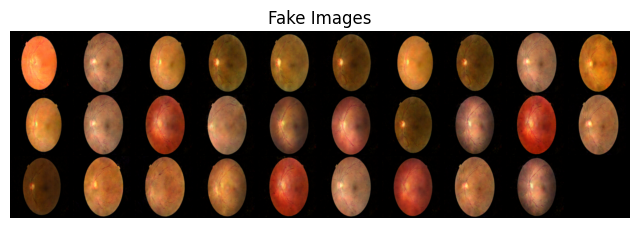

[801/5000][0/9]	Loss_D: 0.0244	Loss_G: 9.3368	D(x): 0.9844	D(G(z)): 0.0044 / 0.0012
[802/5000][0/9]	Loss_D: 0.0003	Loss_G: 9.8051	D(x): 1.0000	D(G(z)): 0.0002 / 0.0005
[803/5000][0/9]	Loss_D: 0.0017	Loss_G: 7.7470	D(x): 0.9999	D(G(z)): 0.0015 / 0.0013
[804/5000][0/9]	Loss_D: 0.0866	Loss_G: 6.7230	D(x): 1.0000	D(G(z)): 0.0484 / 0.0075
[805/5000][0/9]	Loss_D: 0.0004	Loss_G: 10.3975	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[806/5000][0/9]	Loss_D: 0.0015	Loss_G: 9.3414	D(x): 1.0000	D(G(z)): 0.0015 / 0.0066
[807/5000][0/9]	Loss_D: 0.0014	Loss_G: 8.5202	D(x): 0.9999	D(G(z)): 0.0012 / 0.0060
[808/5000][0/9]	Loss_D: 0.0035	Loss_G: 14.5034	D(x): 0.9966	D(G(z)): 0.0000 / 0.0000
[809/5000][0/9]	Loss_D: 0.0004	Loss_G: 11.5767	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[810/5000][0/9]	Loss_D: 0.0003	Loss_G: 10.6346	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[811/5000][0/9]	Loss_D: 0.0002	Loss_G: 10.8601	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[812/5000][0/9]	Loss_D: 0.0001	Loss_G: 11.1683	D(x): 0.9999	D(G(z)): 0.

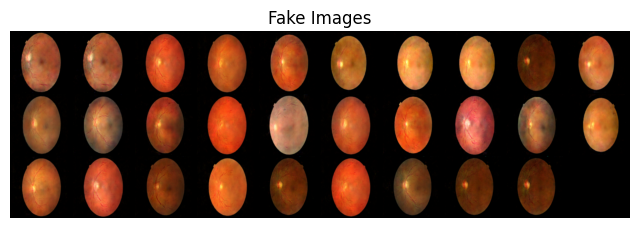

[901/5000][0/9]	Loss_D: 0.0365	Loss_G: 7.8095	D(x): 0.9997	D(G(z)): 0.0347 / 0.0035
[902/5000][0/9]	Loss_D: 0.0009	Loss_G: 14.1812	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[903/5000][0/9]	Loss_D: 0.0013	Loss_G: 11.0921	D(x): 0.9996	D(G(z)): 0.0009 / 0.0009
[904/5000][0/9]	Loss_D: 0.0085	Loss_G: 8.3494	D(x): 0.9996	D(G(z)): 0.0081 / 0.0043
[905/5000][0/9]	Loss_D: 0.0018	Loss_G: 12.0543	D(x): 0.9984	D(G(z)): 0.0001 / 0.0001
[906/5000][0/9]	Loss_D: 0.0067	Loss_G: 6.7082	D(x): 1.0000	D(G(z)): 0.0066 / 0.0152
[907/5000][0/9]	Loss_D: 0.0008	Loss_G: 10.2713	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002
[908/5000][0/9]	Loss_D: 0.0034	Loss_G: 8.1393	D(x): 0.9997	D(G(z)): 0.0032 / 0.0032
[909/5000][0/9]	Loss_D: 0.0004	Loss_G: 10.0824	D(x): 0.9998	D(G(z)): 0.0002 / 0.0003
[910/5000][0/9]	Loss_D: 0.0028	Loss_G: 9.1314	D(x): 0.9980	D(G(z)): 0.0008 / 0.0012
[911/5000][0/9]	Loss_D: 0.0030	Loss_G: 8.4759	D(x): 0.9997	D(G(z)): 0.0026 / 0.0019
[912/5000][0/9]	Loss_D: 0.0025	Loss_G: 8.8751	D(x): 0.9984	D(G(z)): 0.0

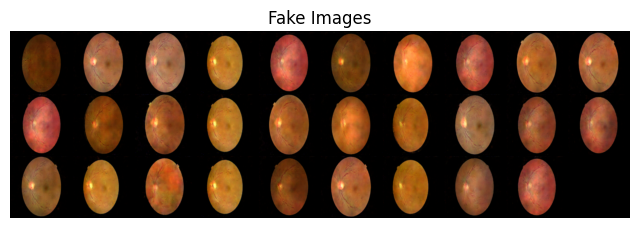

[1001/5000][0/9]	Loss_D: 0.0017	Loss_G: 8.7095	D(x): 0.9995	D(G(z)): 0.0012 / 0.0011
[1002/5000][0/9]	Loss_D: 0.0015	Loss_G: 8.2741	D(x): 0.9993	D(G(z)): 0.0008 / 0.0008
[1003/5000][0/9]	Loss_D: 1.6318	Loss_G: 19.5606	D(x): 1.0000	D(G(z)): 0.5843 / 0.0000
[1004/5000][0/9]	Loss_D: 0.0018	Loss_G: 11.8517	D(x): 0.9987	D(G(z)): 0.0004 / 0.0004
[1005/5000][0/9]	Loss_D: 0.0003	Loss_G: 12.0908	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1006/5000][0/9]	Loss_D: 0.0013	Loss_G: 8.3590	D(x): 0.9998	D(G(z)): 0.0010 / 0.0009
[1007/5000][0/9]	Loss_D: 0.0180	Loss_G: 6.5925	D(x): 0.9902	D(G(z)): 0.0077 / 0.0041
[1008/5000][0/9]	Loss_D: 0.9412	Loss_G: 14.9394	D(x): 1.0000	D(G(z)): 0.3597 / 0.0000
[1009/5000][0/9]	Loss_D: 0.0069	Loss_G: 11.0691	D(x): 0.9999	D(G(z)): 0.0063 / 0.0014
[1010/5000][0/9]	Loss_D: 0.0086	Loss_G: 8.0693	D(x): 1.0000	D(G(z)): 0.0085 / 0.0062
[1011/5000][0/9]	Loss_D: 0.0002	Loss_G: 9.7038	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[1012/5000][0/9]	Loss_D: 0.0038	Loss_G: 8.8258	D(x): 0.9976	

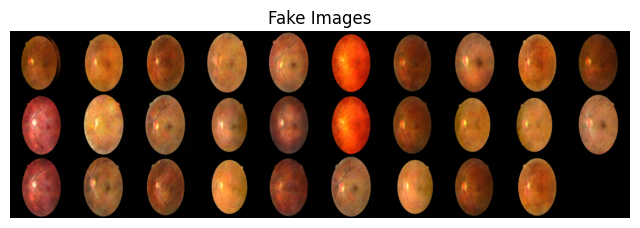

[1101/5000][0/9]	Loss_D: 0.1448	Loss_G: 6.0783	D(x): 1.0000	D(G(z)): 0.0658 / 0.0494
[1102/5000][0/9]	Loss_D: 0.3984	Loss_G: 9.5247	D(x): 1.0000	D(G(z)): 0.1307 / 0.0027
[1103/5000][0/9]	Loss_D: 0.0009	Loss_G: 10.6580	D(x): 0.9999	D(G(z)): 0.0008 / 0.0007
[1104/5000][0/9]	Loss_D: 0.0022	Loss_G: 8.4919	D(x): 0.9999	D(G(z)): 0.0021 / 0.0016
[1105/5000][0/9]	Loss_D: 0.0054	Loss_G: 7.3882	D(x): 1.0000	D(G(z)): 0.0053 / 0.0033
[1106/5000][0/9]	Loss_D: 0.0228	Loss_G: 5.8801	D(x): 1.0000	D(G(z)): 0.0220 / 0.0065
[1107/5000][0/9]	Loss_D: 0.0021	Loss_G: 7.3010	D(x): 0.9999	D(G(z)): 0.0020 / 0.0018
[1108/5000][0/9]	Loss_D: 0.0007	Loss_G: 9.5872	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[1109/5000][0/9]	Loss_D: 0.0293	Loss_G: 6.3714	D(x): 0.9999	D(G(z)): 0.0243 / 0.0029
[1110/5000][0/9]	Loss_D: 0.0004	Loss_G: 9.2376	D(x): 0.9999	D(G(z)): 0.0003 / 0.0004
[1111/5000][0/9]	Loss_D: 0.0022	Loss_G: 7.4762	D(x): 0.9995	D(G(z)): 0.0016 / 0.0015
[1112/5000][0/9]	Loss_D: 0.0153	Loss_G: 5.1918	D(x): 1.0000	D(G(

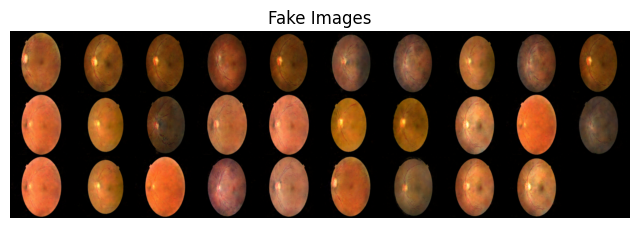

[1201/5000][0/9]	Loss_D: 0.0029	Loss_G: 7.0565	D(x): 0.9991	D(G(z)): 0.0020 / 0.0020
[1202/5000][0/9]	Loss_D: 2.7755	Loss_G: 26.3267	D(x): 1.0000	D(G(z)): 0.7432 / 0.0000
[1203/5000][0/9]	Loss_D: 0.0369	Loss_G: 7.6361	D(x): 0.9994	D(G(z)): 0.0330 / 0.0042
[1204/5000][0/9]	Loss_D: 0.0041	Loss_G: 7.1386	D(x): 0.9999	D(G(z)): 0.0040 / 0.0026
[1205/5000][0/9]	Loss_D: 0.0030	Loss_G: 6.9973	D(x): 0.9999	D(G(z)): 0.0029 / 0.0025
[1206/5000][0/9]	Loss_D: 0.0921	Loss_G: 5.6460	D(x): 0.9992	D(G(z)): 0.0831 / 0.0054
[1207/5000][0/9]	Loss_D: 0.0005	Loss_G: 9.4687	D(x): 0.9997	D(G(z)): 0.0002 / 0.0001
[1208/5000][0/9]	Loss_D: 0.0026	Loss_G: 7.1271	D(x): 0.9990	D(G(z)): 0.0015 / 0.0013
[1209/5000][0/9]	Loss_D: 0.2664	Loss_G: 8.2172	D(x): 1.0000	D(G(z)): 0.2043 / 0.0008
[1210/5000][0/9]	Loss_D: 0.0003	Loss_G: 10.0712	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1211/5000][0/9]	Loss_D: 0.0073	Loss_G: 6.5542	D(x): 1.0000	D(G(z)): 0.0072 / 0.0049
[1212/5000][0/9]	Loss_D: 0.0084	Loss_G: 6.7245	D(x): 0.9982	D(G

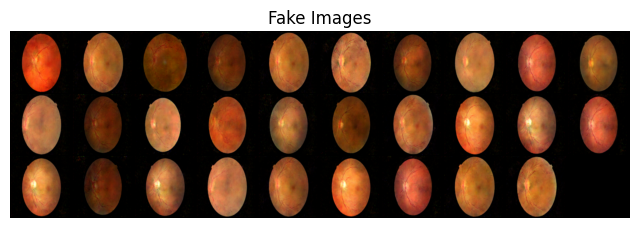

[1301/5000][0/9]	Loss_D: 0.0778	Loss_G: 10.1392	D(x): 1.0000	D(G(z)): 0.0664 / 0.0023
[1302/5000][0/9]	Loss_D: 0.0036	Loss_G: 9.0534	D(x): 1.0000	D(G(z)): 0.0036 / 0.0019
[1303/5000][0/9]	Loss_D: 0.0058	Loss_G: 11.7148	D(x): 0.9950	D(G(z)): 0.0008 / 0.0009
[1304/5000][0/9]	Loss_D: 0.0001	Loss_G: 15.1785	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1305/5000][0/9]	Loss_D: 0.0004	Loss_G: 10.6047	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[1306/5000][0/9]	Loss_D: 0.0001	Loss_G: 12.1662	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1307/5000][0/9]	Loss_D: 0.0003	Loss_G: 10.8384	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[1308/5000][0/9]	Loss_D: 1.0892	Loss_G: 17.6679	D(x): 1.0000	D(G(z)): 0.3366 / 0.0000
[1309/5000][0/9]	Loss_D: 0.0005	Loss_G: 18.5069	D(x): 0.9996	D(G(z)): 0.0001 / 0.0000
[1310/5000][0/9]	Loss_D: 0.0013	Loss_G: 14.1928	D(x): 0.9999	D(G(z)): 0.0012 / 0.0012
[1311/5000][0/9]	Loss_D: 0.0128	Loss_G: 12.8728	D(x): 1.0000	D(G(z)): 0.0117 / 0.0101
[1312/5000][0/9]	Loss_D: 0.0018	Loss_G: 14.9910	D(x): 0

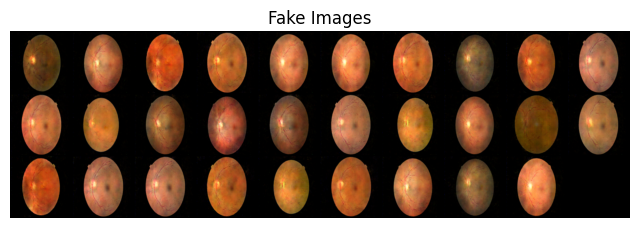

[1401/5000][0/9]	Loss_D: 0.0032	Loss_G: 6.8954	D(x): 1.0000	D(G(z)): 0.0032 / 0.0022
[1402/5000][0/9]	Loss_D: 0.0016	Loss_G: 7.7576	D(x): 0.9999	D(G(z)): 0.0015 / 0.0011
[1403/5000][0/9]	Loss_D: 9.3085	Loss_G: 29.7344	D(x): 1.0000	D(G(z)): 0.9740 / 0.0000
[1404/5000][0/9]	Loss_D: 0.0237	Loss_G: 11.4599	D(x): 1.0000	D(G(z)): 0.0152 / 0.0015
[1405/5000][0/9]	Loss_D: 0.0059	Loss_G: 6.5630	D(x): 1.0000	D(G(z)): 0.0056 / 0.0048
[1406/5000][0/9]	Loss_D: 0.0563	Loss_G: 6.4203	D(x): 1.0000	D(G(z)): 0.0477 / 0.0050
[1407/5000][0/9]	Loss_D: 0.0018	Loss_G: 8.4729	D(x): 0.9999	D(G(z)): 0.0017 / 0.0005
[1408/5000][0/9]	Loss_D: 0.0102	Loss_G: 6.7467	D(x): 1.0000	D(G(z)): 0.0098 / 0.0028
[1409/5000][0/9]	Loss_D: 0.2241	Loss_G: 10.7029	D(x): 1.0000	D(G(z)): 0.1780 / 0.0001
[1410/5000][0/9]	Loss_D: 0.0068	Loss_G: 7.8768	D(x): 1.0000	D(G(z)): 0.0067 / 0.0028
[1411/5000][0/9]	Loss_D: 0.0152	Loss_G: 6.7880	D(x): 1.0000	D(G(z)): 0.0149 / 0.0047
[1412/5000][0/9]	Loss_D: 0.0021	Loss_G: 7.2273	D(x): 0.9995	D(

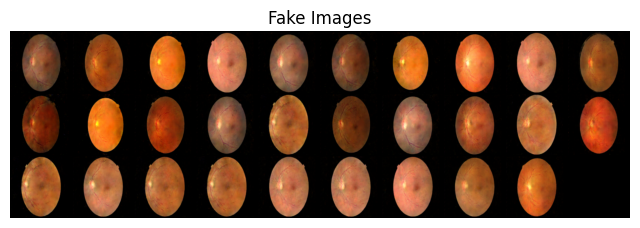

[1501/5000][0/9]	Loss_D: 0.0007	Loss_G: 9.1669	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004
[1502/5000][0/9]	Loss_D: 0.0006	Loss_G: 10.2337	D(x): 0.9997	D(G(z)): 0.0003 / 0.0001
[1503/5000][0/9]	Loss_D: 0.0101	Loss_G: 6.1981	D(x): 1.0000	D(G(z)): 0.0099 / 0.0054
[1504/5000][0/9]	Loss_D: 0.0002	Loss_G: 9.6458	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[1505/5000][0/9]	Loss_D: 0.0004	Loss_G: 8.4951	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[1506/5000][0/9]	Loss_D: 0.0006	Loss_G: 9.3127	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002
[1507/5000][0/9]	Loss_D: 0.0127	Loss_G: 13.1212	D(x): 0.9876	D(G(z)): 0.0000 / 0.0000
[1508/5000][0/9]	Loss_D: 0.0008	Loss_G: 9.3913	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002
[1509/5000][0/9]	Loss_D: 0.0072	Loss_G: 6.0898	D(x): 0.9986	D(G(z)): 0.0057 / 0.0043
[1510/5000][0/9]	Loss_D: 1.0231	Loss_G: 16.6617	D(x): 1.0000	D(G(z)): 0.3264 / 0.0001
[1511/5000][0/9]	Loss_D: 0.0020	Loss_G: 15.9028	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000
[1512/5000][0/9]	Loss_D: 0.0017	Loss_G: 9.2062	D(x): 0.9998	D

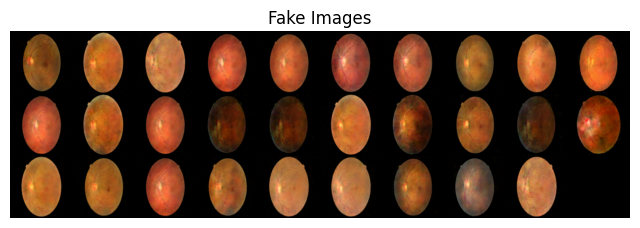

[1601/5000][0/9]	Loss_D: 0.0005	Loss_G: 9.4891	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[1602/5000][0/9]	Loss_D: 0.0014	Loss_G: 7.8357	D(x): 1.0000	D(G(z)): 0.0014 / 0.0012
[1603/5000][0/9]	Loss_D: 0.0008	Loss_G: 8.2637	D(x): 1.0000	D(G(z)): 0.0008 / 0.0006
[1604/5000][0/9]	Loss_D: 0.0081	Loss_G: 6.3614	D(x): 0.9994	D(G(z)): 0.0074 / 0.0050
[1605/5000][0/9]	Loss_D: 0.0001	Loss_G: 11.1199	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1606/5000][0/9]	Loss_D: 0.9349	Loss_G: 16.0139	D(x): 1.0000	D(G(z)): 0.4336 / 0.0000
[1607/5000][0/9]	Loss_D: 0.0129	Loss_G: 16.2230	D(x): 0.9908	D(G(z)): 0.0000 / 0.0000
[1608/5000][0/9]	Loss_D: 0.0017	Loss_G: 9.8813	D(x): 0.9997	D(G(z)): 0.0013 / 0.0006
[1609/5000][0/9]	Loss_D: 0.0003	Loss_G: 10.8017	D(x): 0.9998	D(G(z)): 0.0001 / 0.0002
[1610/5000][0/9]	Loss_D: 0.0007	Loss_G: 9.4060	D(x): 0.9999	D(G(z)): 0.0006 / 0.0004
[1611/5000][0/9]	Loss_D: 0.0037	Loss_G: 7.6744	D(x): 0.9998	D(G(z)): 0.0034 / 0.0057
[1612/5000][0/9]	Loss_D: 0.0003	Loss_G: 10.6939	D(x): 0.9998	

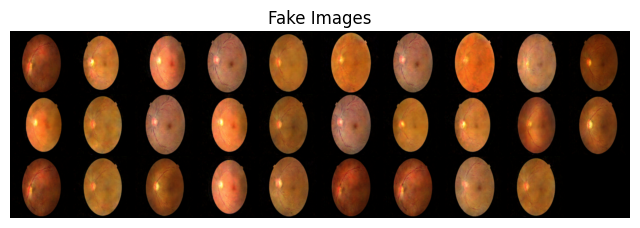

[1701/5000][0/9]	Loss_D: 0.0019	Loss_G: 13.6963	D(x): 0.9989	D(G(z)): 0.0007 / 0.0006
[1702/5000][0/9]	Loss_D: 0.0042	Loss_G: 11.6852	D(x): 0.9999	D(G(z)): 0.0041 / 0.0028
[1703/5000][0/9]	Loss_D: 0.0002	Loss_G: 13.4047	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1704/5000][0/9]	Loss_D: 0.0082	Loss_G: 11.0864	D(x): 0.9924	D(G(z)): 0.0001 / 0.0002
[1705/5000][0/9]	Loss_D: 0.0009	Loss_G: 10.2706	D(x): 0.9993	D(G(z)): 0.0002 / 0.0001
[1706/5000][0/9]	Loss_D: 0.0042	Loss_G: 9.5944	D(x): 1.0000	D(G(z)): 0.0042 / 0.0030
[1707/5000][0/9]	Loss_D: 0.0009	Loss_G: 12.4636	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001
[1708/5000][0/9]	Loss_D: 0.0068	Loss_G: 7.3477	D(x): 0.9998	D(G(z)): 0.0066 / 0.0038
[1709/5000][0/9]	Loss_D: 0.0027	Loss_G: 9.4183	D(x): 0.9977	D(G(z)): 0.0004 / 0.0004
[1710/5000][0/9]	Loss_D: 0.0160	Loss_G: 12.4921	D(x): 0.9869	D(G(z)): 0.0007 / 0.0032
[1711/5000][0/9]	Loss_D: 0.0010	Loss_G: 13.9402	D(x): 0.9991	D(G(z)): 0.0001 / 0.0000
[1712/5000][0/9]	Loss_D: 0.0019	Loss_G: 11.5505	D(x): 0.9

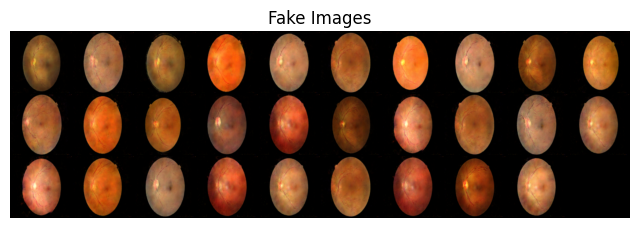

[1801/5000][0/9]	Loss_D: 0.0002	Loss_G: 9.8753	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1802/5000][0/9]	Loss_D: 0.0101	Loss_G: 10.6521	D(x): 0.9909	D(G(z)): 0.0002 / 0.0001
[1803/5000][0/9]	Loss_D: 0.0005	Loss_G: 9.3339	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003
[1804/5000][0/9]	Loss_D: 0.0014	Loss_G: 8.3334	D(x): 0.9996	D(G(z)): 0.0010 / 0.0006
[1805/5000][0/9]	Loss_D: 0.0012	Loss_G: 7.8469	D(x): 0.9999	D(G(z)): 0.0010 / 0.0018
[1806/5000][0/9]	Loss_D: 0.0287	Loss_G: 10.5903	D(x): 0.9757	D(G(z)): 0.0001 / 0.0002
[1807/5000][0/9]	Loss_D: 0.0010	Loss_G: 8.2747	D(x): 0.9999	D(G(z)): 0.0008 / 0.0036
[1808/5000][0/9]	Loss_D: 0.0826	Loss_G: 7.3676	D(x): 0.9995	D(G(z)): 0.0687 / 0.0114
[1809/5000][0/9]	Loss_D: 0.0006	Loss_G: 8.9836	D(x): 1.0000	D(G(z)): 0.0006 / 0.0005
[1810/5000][0/9]	Loss_D: 0.0005	Loss_G: 9.2247	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[1811/5000][0/9]	Loss_D: 0.0031	Loss_G: 7.9036	D(x): 0.9991	D(G(z)): 0.0022 / 0.0016
[1812/5000][0/9]	Loss_D: 0.0013	Loss_G: 8.1184	D(x): 0.9996	D(G

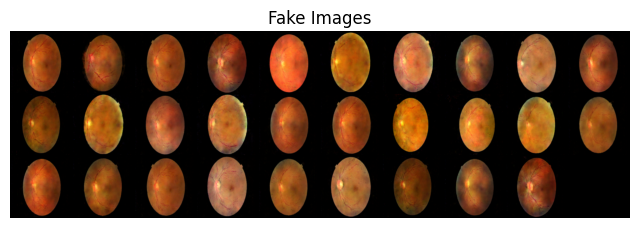

[1901/5000][0/9]	Loss_D: 0.0011	Loss_G: 8.6230	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[1902/5000][0/9]	Loss_D: 0.0006	Loss_G: 9.0092	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004
[1903/5000][0/9]	Loss_D: 0.0039	Loss_G: 9.6286	D(x): 0.9964	D(G(z)): 0.0001 / 0.0003
[1904/5000][0/9]	Loss_D: 0.0007	Loss_G: 10.2892	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[1905/5000][0/9]	Loss_D: 0.0030	Loss_G: 6.9220	D(x): 1.0000	D(G(z)): 0.0030 / 0.0022
[1906/5000][0/9]	Loss_D: 0.0017	Loss_G: 8.5453	D(x): 0.9987	D(G(z)): 0.0004 / 0.0005
[1907/5000][0/9]	Loss_D: 0.0042	Loss_G: 6.8405	D(x): 0.9981	D(G(z)): 0.0023 / 0.0019
[1908/5000][0/9]	Loss_D: 0.0088	Loss_G: 8.1378	D(x): 0.9918	D(G(z)): 0.0004 / 0.0005
[1909/5000][0/9]	Loss_D: 0.0065	Loss_G: 13.9939	D(x): 0.9938	D(G(z)): 0.0000 / 0.0000
[1910/5000][0/9]	Loss_D: 0.0008	Loss_G: 8.9248	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005
[1911/5000][0/9]	Loss_D: 0.0001	Loss_G: 9.7816	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1912/5000][0/9]	Loss_D: 0.0070	Loss_G: 5.9275	D(x): 0.9999	D(G

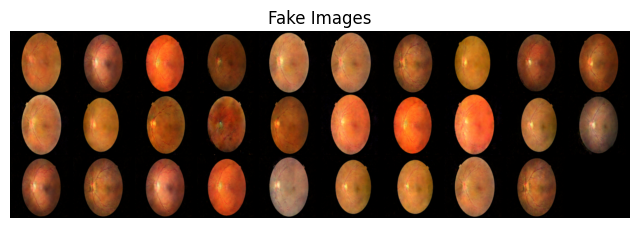

[2001/5000][0/9]	Loss_D: 0.0031	Loss_G: 9.1144	D(x): 0.9999	D(G(z)): 0.0029 / 0.0023
[2002/5000][0/9]	Loss_D: 0.0007	Loss_G: 10.7103	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003
[2003/5000][0/9]	Loss_D: 0.0005	Loss_G: 10.2130	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[2004/5000][0/9]	Loss_D: 0.0012	Loss_G: 12.5127	D(x): 0.9991	D(G(z)): 0.0003 / 0.0002
[2005/5000][0/9]	Loss_D: 0.0105	Loss_G: 8.9556	D(x): 0.9937	D(G(z)): 0.0040 / 0.0035
[2006/5000][0/9]	Loss_D: 0.0007	Loss_G: 9.8486	D(x): 0.9999	D(G(z)): 0.0006 / 0.0005
[2007/5000][0/9]	Loss_D: 0.0010	Loss_G: 9.9108	D(x): 0.9999	D(G(z)): 0.0009 / 0.0008
[2008/5000][0/9]	Loss_D: 0.0001	Loss_G: 13.4360	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2009/5000][0/9]	Loss_D: 0.0052	Loss_G: 8.1489	D(x): 0.9985	D(G(z)): 0.0036 / 0.0028
[2010/5000][0/9]	Loss_D: 0.0001	Loss_G: 13.1802	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2011/5000][0/9]	Loss_D: 0.0012	Loss_G: 10.7129	D(x): 0.9999	D(G(z)): 0.0011 / 0.0010
[2012/5000][0/9]	Loss_D: 0.0028	Loss_G: 8.8250	D(x): 0.9981

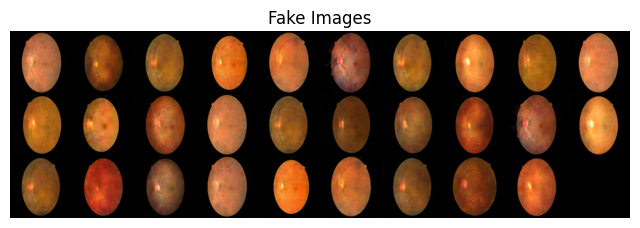

[2101/5000][0/9]	Loss_D: 0.0030	Loss_G: 7.0127	D(x): 0.9997	D(G(z)): 0.0027 / 0.0017
[2102/5000][0/9]	Loss_D: 0.0384	Loss_G: 6.8372	D(x): 0.9992	D(G(z)): 0.0324 / 0.0023
[2103/5000][0/9]	Loss_D: 0.0031	Loss_G: 7.7018	D(x): 0.9982	D(G(z)): 0.0013 / 0.0013
[2104/5000][0/9]	Loss_D: 0.0007	Loss_G: 8.3423	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006
[2105/5000][0/9]	Loss_D: 0.0033	Loss_G: 7.9463	D(x): 0.9976	D(G(z)): 0.0008 / 0.0007
[2106/5000][0/9]	Loss_D: 0.0010	Loss_G: 10.4006	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001
[2107/5000][0/9]	Loss_D: 0.0060	Loss_G: 5.4640	D(x): 1.0000	D(G(z)): 0.0059 / 0.0133
[2108/5000][0/9]	Loss_D: 0.0006	Loss_G: 8.8122	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005
[2109/5000][0/9]	Loss_D: 0.0055	Loss_G: 6.6389	D(x): 0.9998	D(G(z)): 0.0053 / 0.0025
[2110/5000][0/9]	Loss_D: 0.0006	Loss_G: 9.0694	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002
[2111/5000][0/9]	Loss_D: 0.0015	Loss_G: 8.5982	D(x): 0.9990	D(G(z)): 0.0004 / 0.0004
[2112/5000][0/9]	Loss_D: 0.0029	Loss_G: 6.6034	D(x): 0.9999	D(G(

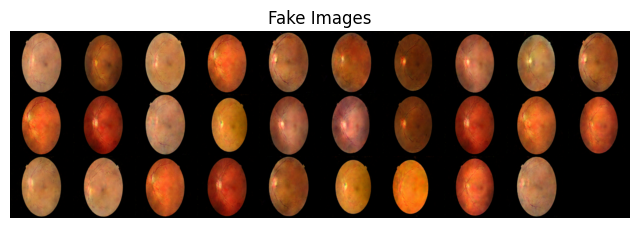

[2201/5000][0/9]	Loss_D: 0.0020	Loss_G: 7.4120	D(x): 0.9998	D(G(z)): 0.0018 / 0.0014
[2202/5000][0/9]	Loss_D: 0.5490	Loss_G: 18.7870	D(x): 1.0000	D(G(z)): 0.2644 / 0.0000
[2203/5000][0/9]	Loss_D: 0.0019	Loss_G: 11.7328	D(x): 1.0000	D(G(z)): 0.0018 / 0.0009
[2204/5000][0/9]	Loss_D: 0.0007	Loss_G: 9.8649	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[2205/5000][0/9]	Loss_D: 0.0025	Loss_G: 8.2231	D(x): 1.0000	D(G(z)): 0.0024 / 0.0018
[2206/5000][0/9]	Loss_D: 0.0011	Loss_G: 9.1919	D(x): 0.9993	D(G(z)): 0.0004 / 0.0004
[2207/5000][0/9]	Loss_D: 0.0009	Loss_G: 8.0143	D(x): 0.9999	D(G(z)): 0.0008 / 0.0007
[2208/5000][0/9]	Loss_D: 0.0004	Loss_G: 11.1446	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[2209/5000][0/9]	Loss_D: 0.0107	Loss_G: 6.6464	D(x): 0.9996	D(G(z)): 0.0101 / 0.0022
[2210/5000][0/9]	Loss_D: 0.0008	Loss_G: 9.7405	D(x): 0.9995	D(G(z)): 0.0003 / 0.0001
[2211/5000][0/9]	Loss_D: 0.0004	Loss_G: 9.7460	D(x): 0.9998	D(G(z)): 0.0002 / 0.0001
[2212/5000][0/9]	Loss_D: 0.0267	Loss_G: 6.5334	D(x): 0.9990	D(

In [ ]:
# Training
    
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
good_Training=False
#noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

if __name__=='__main__':
    print("Starting Training Loop...")
    #netG.load_state_dict(torch.load('/kaggle/input/weights128-2000/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/input/weights128-2000/discriminator.weight'))#,map_location=torch.device('cpu')
    
    netG.load_state_dict(torch.load('/kaggle/input/weights-6500/generator.weight'))
    netD.load_state_dict(torch.load('/kaggle/input/weights-6500/discriminator.weight'))
    
    #netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))
    #netD.load_state_dict(torch.load('/kaggle/working/discriminator.weight'))

    for epoch in range(EPOCH_NUM):
        for i, data in enumerate(dataloader, 0):
            # (1) Update the discriminator with real data
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            #print(b_size)

            label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            # (2) Update the discriminator with fake data
            # Generate batch of latent vectors
            noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
            
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(FAKE_LABEL)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (3) Update the generator with fake data
            netG.zero_grad()
            label.fill_(REAL_LABEL)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 9 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, EPOCH_NUM, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
        if ((epoch+1)%5==0):
            avg_G_Loss=sum(G_losses[-5:])/5
            avg_D_Loss=sum(D_losses[-5:])/5
            if avg_G_Loss>=20 or avg_D_Loss>=5 or avg_D_Loss==0:
                print('Exited')
                break
        
        if ((epoch+1)%100==0):
            print("........Saving.......")
            %mkdir /kaggle/working/{epoch+1}
            torch.save(netG.state_dict(), f'/kaggle/working/{epoch+1}/generator.weight')
            torch.save(netD.state_dict(), f'/kaggle/working/{epoch+1}/discriminator.weight')
            with torch.no_grad():
                fake = netG(noise).detach().cpu()
            img_list.append(fake)
            display_images(img_list)


In [ ]:
#plot loss graph

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Generate image
%mkdir /kaggle/working/Generated_Batch
def save_image(fake):
    print('Generated Image Size: ',fake[0].shape)
    for i,genrated_image in enumerate(fake):
        #print(i)
        genrated_image = np.moveaxis(genrated_image, 0, -1)
        #print(genrated_image.shape)
        m = np.min(genrated_image)
        M = np.max(genrated_image)
        genrated_image = (genrated_image-m)/(M-m)
        genrated_image = 255*genrated_image
        genrated_image = np.array(genrated_image, dtype='uint8')
        #plt.imshow(genrated_image)
        #plt.show()
        plt.imsave(f'/kaggle/working/Generated_Batch/{i}.png', genrated_image)

def display_image(dataloader,str):
    # Plot some training images
    Data=dataloader #next(iter(dataloader))
    #print(Data.shape)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{str} Images")
    plt.imshow(np.transpose(vutils.make_grid(Data[:64],nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

if __name__=='__main__':
    c=0
    #netG = generator()
    netG.to(device)
    #netG.load_state_dict(torch.load('/kaggle/input/weights-6300/generator.weight'))
    #netG.load_state_dict(torch.load('/kaggle/working/200/generator.weight'))
    #netG.load_state_dict(torch.load('/kaggle/input/weights128-3000/generator.weight'))
    

    noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    with torch.no_grad():
        #print(noise.shape)
        fake = netG(noise)#.detach().cpu()#.numpy()
    
    #save_image(netG(noise).detach().cpu().numpy())
        
    display_image(fake,'Fake')

    #display_image(img_list[-2],'Fake')
    #display_image(img_list[-1],'Fake')


In [ ]:
import shutil

source_folder = '/kaggle/working/Generated_Batch'
output_path = '/kaggle/working/'

#shutil.make_archive('Output', 'zip', source_folder)

In [ ]:
#%lsmagic
#%rm -rf /kaggle/working/*
#%tar -cf outputs.tar /kaggle/working/Generated_Batch
#%apt update && sudo apt install zip